In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.core.display import display
from sklearn.model_selection import train_test_split
%matplotlib inline

from skimage import io
import os

paths = [f'../static/{path}' for path in os.listdir('../static/')]

paths.sort()

#     io.imread(f'./images/{path}')
# file = io.imread(f'./images/2013_03_01_00_00_00.jpg')

In [22]:
images = io.imread_collection(paths, conserve_memory=False)
data = [image.ravel()/255. for image in images]
data = data[:4446]

rains = pd.read_csv('../data/is_rainy.csv', header=None)
rains = [1 if rain else 0 for rain in rains[0]]

In [23]:
X_train_raw, X_test_raw = data[:-730], data[-730:]
y_train, y_test = rains[:-730], rains[-730:]

In [24]:
print(len(data))
print(len(rains))

4446
4446


In [27]:
file = io.imread('../static/2019_02_11_09_00_00.jpg')
file.shape

(80, 120)

In [44]:
# best_nmf.transform([file.ravel()/.255])

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import NMF

param_grid = {
    'svc__C':  [1, 10, 100],
    'svc__gamma': [0.01, 0.1, 1],
}

pipe = make_pipeline(
    NMF(n_components=30, random_state=0),
    SVC(random_state=0)
)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_search.fit(X_train_raw, y_train)

print("test set score: {:.3f}".format(grid_search.score(X_test_raw, y_test)))
print("best params: {}".format(grid_search.best_params_))
print("best cross-validation score: {:.3f}".format(grid_search.best_score_))

KeyboardInterrupt: 

In [ ]:
best_nmf = grid_search.best_estimator_.named_steps['nmf']
best_svc = grid_search.best_estimator_.named_steps['svc']

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import NMF

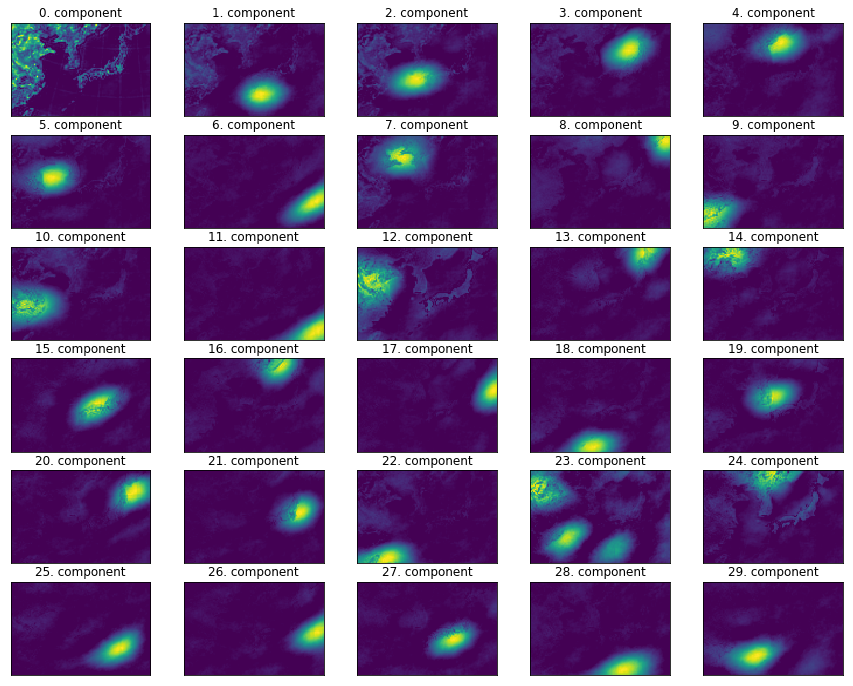

In [50]:
X_train_nmf = best_nmf.transform(X_train_raw)
X_test_nmf = best_nmf.transform(X_test_raw)

image_shape = images[0].shape
fix, axes = plt.subplots(6, 5, figsize=(15,12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component,ax) in enumerate(zip(best_nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

In [51]:
def draw_nmf_top_rated(compn):
    inds = np.argsort(X_train_nmf[:, compn])[::-1]
    fix, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})

    for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
        ax.imshow(data[ind].reshape(image_shape))

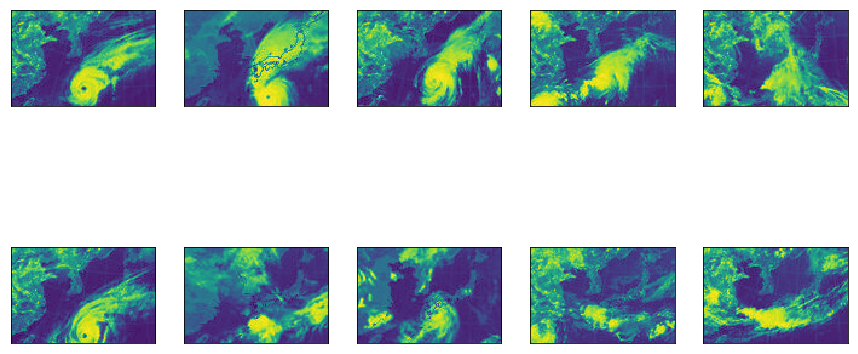

In [52]:
draw_nmf_top_rated(1)

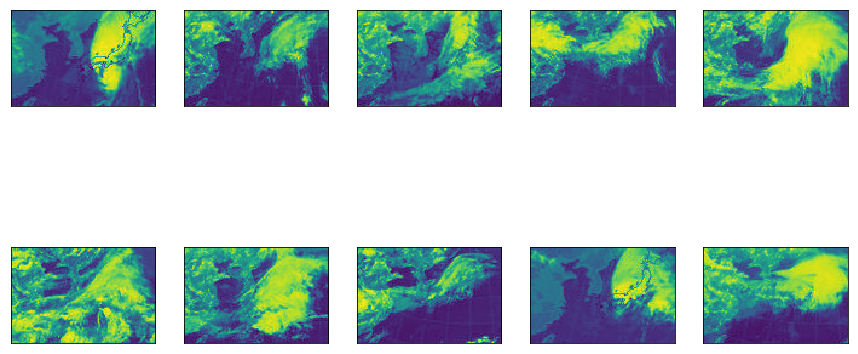

In [53]:
draw_nmf_top_rated(3)

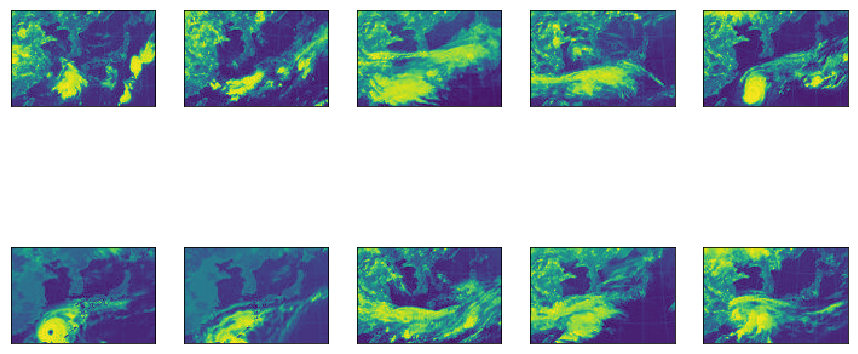

In [54]:
draw_nmf_top_rated(29)

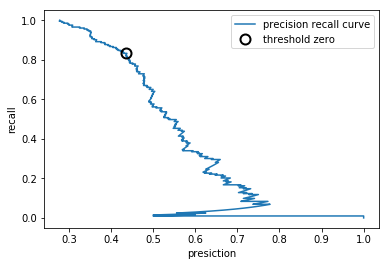

In [55]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, best_svc.decision_function(X_test_nmf))

plt.plot(precision, recall, label='precision recall curve')
plt.xlabel('presiction')
plt.ylabel('recall')

close_zero = np.argmin(np.abs(thresholds+0.96))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.legend(loc=1)

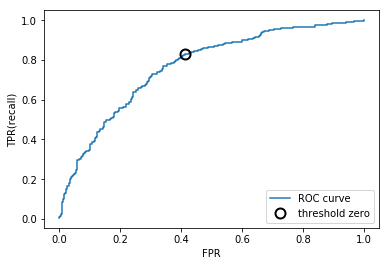

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, best_svc.decision_function(X_test_nmf))

plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')

close_zero = np.argmin(np.abs(thresholds+0.96))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

In [ ]:
from sklearn.metrics import confusion_matrix

X_pred = best_svc.predict(X_test_nmf)
print(confusion_matrix(y_test, X_pred))

In [ ]:
from sklearn.metrics import classification_report

X_pred = best_svc.predict(X_test_nmf)
print(classification_report(y_test, X_pred))

In [ ]:
X_pred_low_thres = best_svc.decision_function(X_test_nmf) >= -0.96

print(classification_report(y_test, X_pred_low_thres))

In [ ]:
import pickle

with open('./flask/data/weather_nmf_nmf2.pickle', 'wb') as fp:
    pickle.dump(best_nmf, fp)

with open('./flask/data/weather_nmf_svc2.pickle', 'wb') as fp:
    pickle.dump(best_svc, fp)

In [30]:
import pickle

with open('../data/weather_nmf_nmf.pickle', 'rb') as fp:
    best_nmf = pickle.load(fp)

with open('../data/weather_nmf_svc.pickle', 'rb') as fp:
    best_svc = pickle.load(fp)